<a href="https://colab.research.google.com/github/G-Gaddu/Quant-Connect/blob/main/Volatility_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.8 MB/s eta 0:00:00


In [2]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# Get the data
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2023, 1, 1)
ticker = '^FTSE'
data = yf.download(ticker, start=start, end=end)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,6749.100098,6759.399902,6707.500000,6717.899902,6717.899902,459529100
2014-01-03,6717.899902,6747.299805,6699.299805,6730.700195,6730.700195,374841500
2014-01-06,6730.700195,6752.000000,6714.600098,6730.700195,6730.700195,524387000
2014-01-07,6730.700195,6768.899902,6718.100098,6755.500000,6755.500000,672375600
2014-01-08,6755.500000,6755.500000,6713.399902,6721.799805,6721.799805,720025300


In [4]:
data_close = data['Close']
data_close.head()

,Close
Date,
2014-01-02,6717.899902
2014-01-03,6730.700195
2014-01-06,6730.700195
2014-01-07,6755.500000
2014-01-08,6721.799805


In [5]:
# Determine the log returns
data_close['Log_Ret'] = np.pad(np.diff(np.log(data_close))*100, (1,0), 'constant', constant_values=np.nan)

<ipython-input-5-1c1c6a0c6ae5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_close['Log_Ret'] = np.pad(np.diff(np.log(data_close))*100, (1,0), 'constant', constant_values=np.nan)


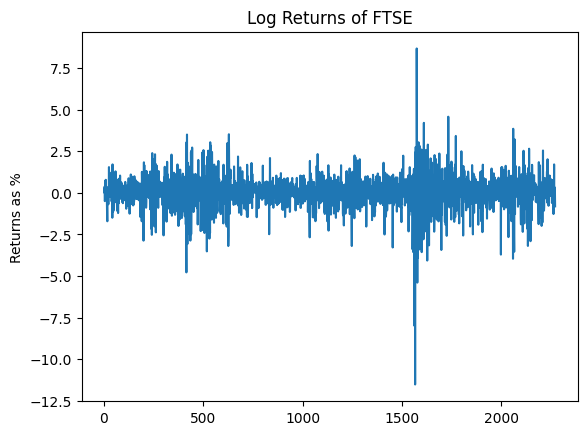

In [6]:
# Plot them
plt.figure()
plt.plot(data_close['Log_Ret'])
plt.title('Log Returns of FTSE')
plt.ylabel('Returns as %')
plt.show()

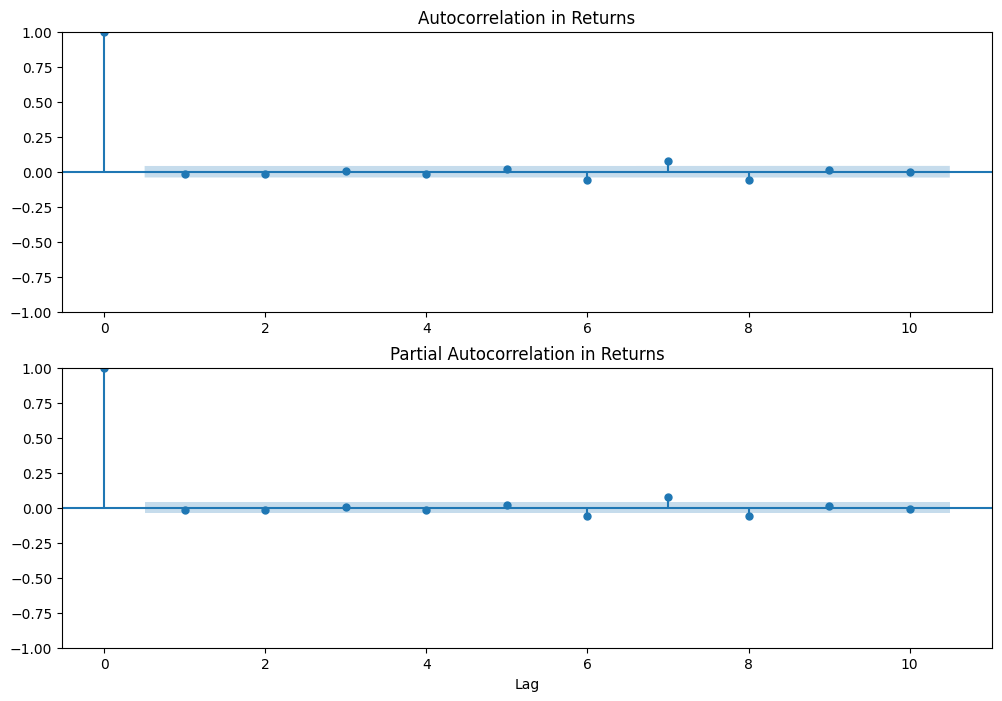

In [7]:
# Plot the ACFs and PACFs
plot_data = pd.DataFrame(data_close['Log_Ret'])
diff_ts = plot_data.iloc[1:]
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(diff_ts, ax=ax1, lags=10)
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_xlabel('Lag')
ax1.set_title('Autocorrelation in Returns')
ax2.set_title('Partial Autocorrelation in Returns')
plt.show()


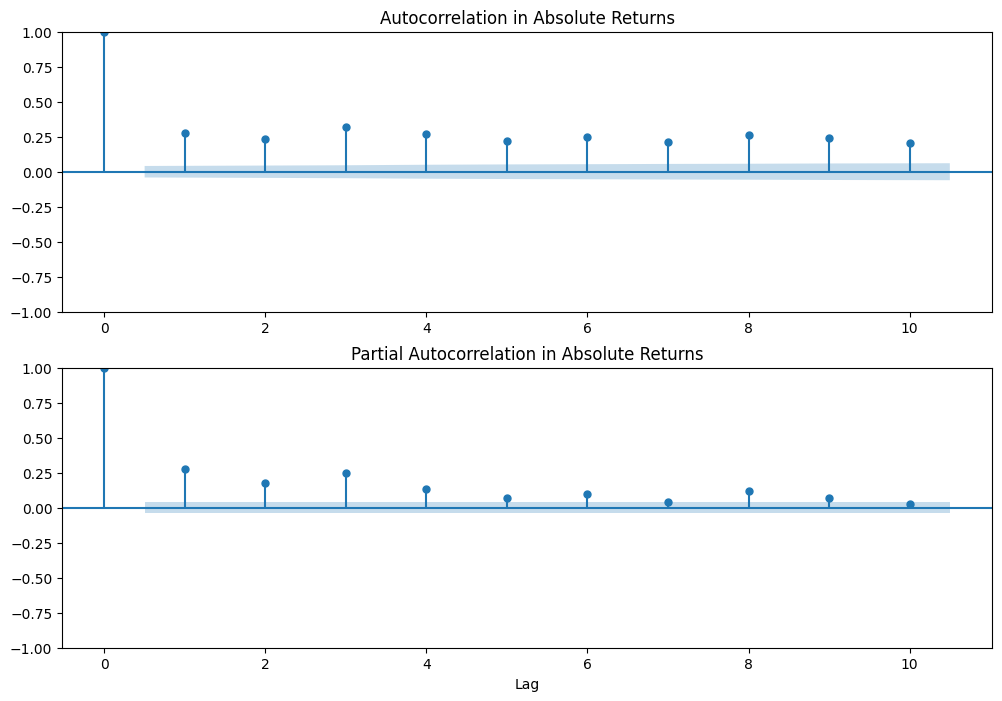

In [8]:
# To confirm this  we repeat the process but with absolute returns (we can use squared returns but absolute minimises the effects of outliers)
abs_data = diff_ts.abs()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(abs_data, ax=ax1, lags=10)
plot_pacf(abs_data, ax=ax2, lags=10)
ax2.set_xlabel('Lag')
ax1.set_title('Autocorrelation in Absolute Returns')
ax2.set_title('Partial Autocorrelation in Absolute Returns')
plt.show()

In [9]:
# Create a McLeod Li test to check for white noice behavior in the residuals of the series
def mcleod_li_test(a,k):
  n = len(a)
  a_sq = a ** 2
  a_sq_sum = np.sum(a_sq)
  a_lag_sum = np.sum(a_sq[:-k])
  test_stat = n*(n+2)*a_lag_sum/(a_sq_sum**2)
  df = k
  p_value = 1 -chi2.cdf(test_stat, df)
  return test_stat, p_value


In [10]:
# Get the stats
mcli_stat, p_value = mcleod_li_test(abs_data, 50)
print("McLeod Li Test:")
print("Test Statistic:", mcli_stat)
print("P-value:", p_value)

McLeod Li Test:
Test Statistic: 0    2139.614105
dtype: float64
P-value: [0.]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [13]:
# We perform a sensitivity analysis on the GARCH model parameters
def garch_sensitivity_analysis(data, p_range, q_range, n_simulations=1):
  results = []
  for p in p_range:
    for q in q_range:
      for _ in range(n_simulations):
        # Fit the GARCH model
        model = arch_model(data, vol='Garch', p=p, q=q)
        res = model.fit(disp='off')

        # Store the results
        results.append({
            'p': p,
            'q': q,
            'log_likelihood': res.loglikelihood,
            'aic': res.aic,
            'bic': res.bic
        })

  return pd.DataFrame(results)


In [15]:
garch_sensitivity_analysis(abs_data, [1,2,3,4,5], [1,2,3,4,5])

,p,q,log_likelihood,aic,bic
0,1,1,-2097.860967,4203.721934,4226.635597
1,1,2,-2092.860566,4195.721131,4224.363210
2,1,3,-2091.151833,4194.303666,4228.674160
3,1,4,-2091.151833,4196.303666,4236.402576
4,1,5,-2091.144008,4198.288015,4244.115341
5,2,1,-2097.860967,4205.721934,4234.364013
6,2,2,-2092.860565,4197.721131,4232.091625
7,2,3,-2090.708693,4195.417385,4235.516296
8,2,4,-2090.708693,4197.417385,4243.244711
9,2,5,-2090.695812,4199.391623,4250.947365


In [16]:
# Fit the GARCH model onto the data using a 80-20 train test split and a defulat GARCH(1,1)
y_train, y_test = train_test_split(abs_data, train_size = 0.8)
GARCH_model = arch_model(y_train, mean = "Zero", vol='Garch',p=5,q=5, rescale=False)
results_garch = GARCH_model.fit()
print(results_garch.summary())

Iteration:      1,   Func. Count:     13,   Neg. LLF: 3998.1306458410872
Iteration:      2,   Func. Count:     30,   Neg. LLF: 3923.6662824666882
Iteration:      3,   Func. Count:     43,   Neg. LLF: 2601.6444022551673
Iteration:      4,   Func. Count:     56,   Neg. LLF: 2827.727323603916
Iteration:      5,   Func. Count:     69,   Neg. LLF: 2452.094334440684
Iteration:      6,   Func. Count:     82,   Neg. LLF: 2521.2447937582974
Iteration:      7,   Func. Count:     95,   Neg. LLF: 2327.405156671408
Iteration:      8,   Func. Count:    108,   Neg. LLF: 2505.893105213612
Iteration:      9,   Func. Count:    122,   Neg. LLF: 2308.580524468293
Iteration:     10,   Func. Count:    135,   Neg. LLF: 2310.8001918643995
Iteration:     11,   Func. Count:    148,   Neg. LLF: 2303.580950864517
Iteration:     12,   Func. Count:    160,   Neg. LLF: 2303.3690078517975
Iteration:     13,   Func. Count:    172,   Neg. LLF: 2303.4683308561803
Iteration:     14,   Func. Count:    185,   Neg. LLF: 230

In [17]:
# Now we can forecast the future volatilities using the model and an N step ahead forecast approach
y_pred = results_garch.forecast(horizon=y_test.shape[0], reindex=True)

In [18]:
print(y_pred)

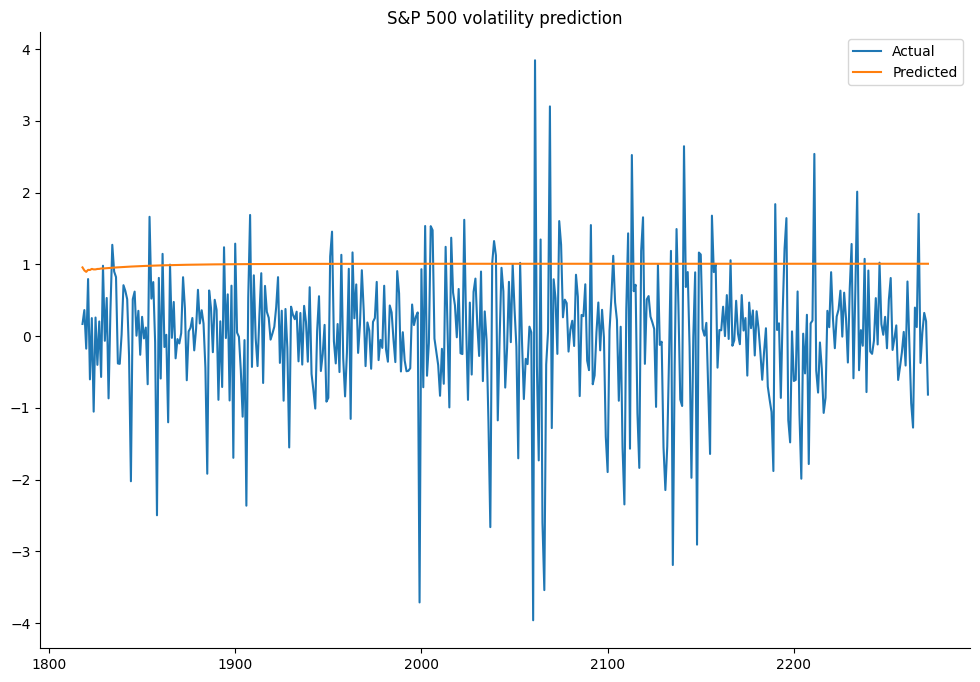

In [19]:
# Plot the predictions against the values
fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['top','right']].set_visible(False)
plt.plot(diff_ts[-y_test.shape[0]:])
plt.plot(y_test.index, np.sqrt(y_pred.variance.values[-1,:]))
plt.title('S&P 500 volatility prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [20]:
mse = mean_squared_error(diff_ts[-y_test.shape[0]:], np.sqrt(y_pred.variance.values[-1,:]))
print("Mean Squared Error:", mse)

Mean Squared Error: 1.8025331727852483


In [21]:
r2 = r2_score(diff_ts[-y_test.shape[0]:], np.sqrt(y_pred.variance.values[-1,:]))
print("R-squared:", r2)

R-squared: -1.1421176549571164


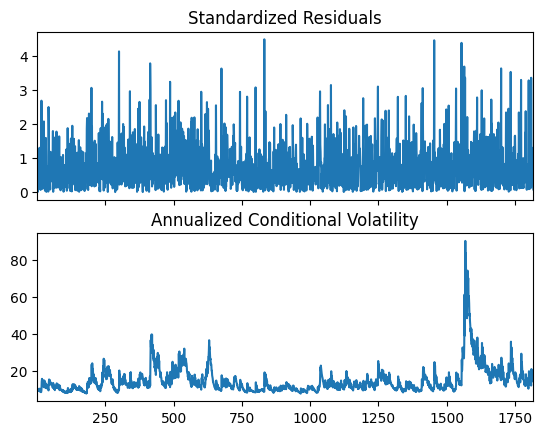

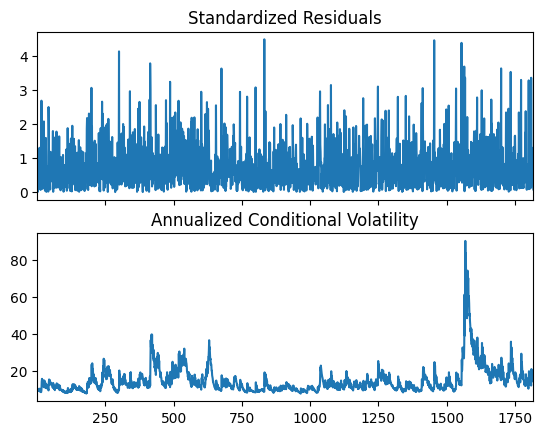

In [22]:
# Conditional volatility by model fitting
results_garch.plot(annualize="D")

In [23]:
# We can also make only one step ahead predictions i.e. predict for the next day only
rolling_ypred = []
for i in range(y_test.shape[0]):
  train = abs_data[:-(y_test.shape[0]-i)]
  model = arch_model(train, p=1,q=1, rescale=False)
  model_fit = model.fit(disp='off')
  preds = model_fit.forecast(horizon=1, reindex=True)
  rolling_ypred.append(np.sqrt(preds.variance.values[-1,:][0]))
rolling_ypred = pd.Series(rolling_ypred, index=y_test.index)

Text(0.5, 1.0, 'FTSE Rolling Volatility Prediction')

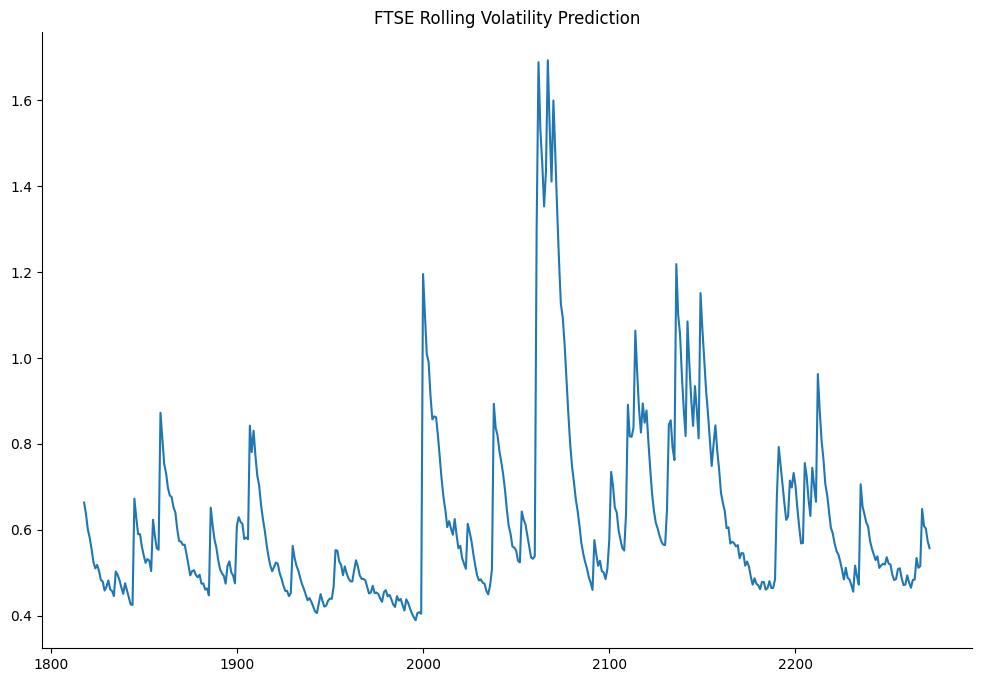

In [24]:
# Plot the predictions
fig,ax = plt.subplots(figsize=(12,8))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_ypred)
plt.title('FTSE Rolling Volatility Prediction')

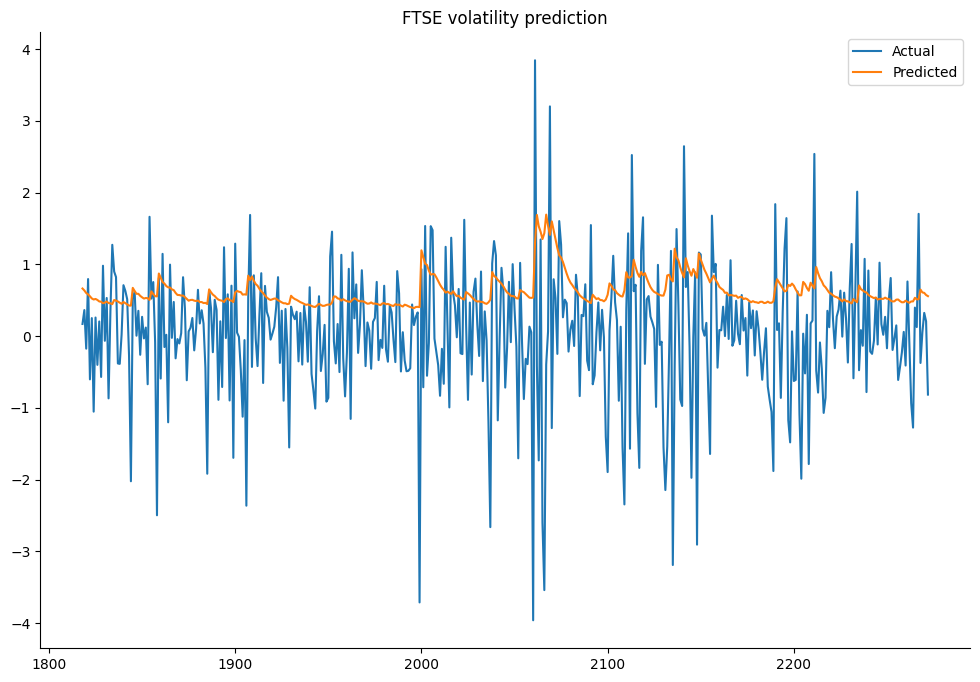

In [25]:
# Plot the actual vs predictions
fig, ax = plt.subplots(figsize=(12,8))
ax.spines[['top','right']].set_visible(False)
ax.plot(diff_ts[-y_test.shape[0]:])
ax.plot(y_test.index, rolling_ypred)
plt.title('FTSE volatility prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()

In [26]:
mse2 = mean_squared_error(diff_ts[-y_test.shape[0]:], rolling_ypred)
print("Mean Squared Error:", mse2)

Mean Squared Error: 1.220236445351442


In [27]:
r22 = r2_score(diff_ts[-y_test.shape[0]:], rolling_ypred)
print("R-squared:", r22)

R-squared: -0.450120348559518


In [29]:
# Determine the Jarque Bera Test figure to test if the residuals follow a normal distribution
std_resid = results_garch.resid/results_garch.conditional_volatility
jb_stat, p_value = jarque_bera(std_resid)
print("Jarque Bera Test:")
print("Test Statistic:", jb_stat)
print("P-value:", p_value)

Jarque Bera Test:
Test Statistic: 1899.4354956651948
P-value: 0.0
